In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import solver

In [8]:
def differential_expression(f, x):
    f_prime = solver.calcGradients(f, x, 1)
    return f_prime - x - 1

def bc_function(x):
    return 0.0

bc_xs = [0.0]
bc_functions = [bc_function]
bc_ps = [0]

loss_fn = solver.LossFunction(differential_expression, bc_xs, bc_functions, bc_ps)

x_min = 0.0
x_max = 1.0
x_num = 200
x = np.linspace(x_min, x_max, x_num)
domain = [[x_min, x_max]]
dataloader = solver.genDataLoader(domain, discretization_num=x_num)

input_dim = 1
output_dim = 1
hidden_shapes = [50, 50]
model = solver.DNN(input_dim, hidden_shapes, output_dim)


num_epochs = 1000
learning_rate = 0.01
loss_history = solver.training(model, loss_fn, dataloader, num_epochs, learning_rate)

Epoch 1/1000 Loss: 2.3523
Epoch 2/1000 Loss: 2.2152
Epoch 3/1000 Loss: 2.0411
Epoch 4/1000 Loss: 1.8876
Epoch 5/1000 Loss: 1.7153
Epoch 6/1000 Loss: 1.5164
Epoch 7/1000 Loss: 1.3016
Epoch 8/1000 Loss: 1.0784
Epoch 9/1000 Loss: 0.8516
Epoch 10/1000 Loss: 0.6290
Epoch 11/1000 Loss: 0.4260
Epoch 12/1000 Loss: 0.2661
Epoch 13/1000 Loss: 0.1680
Epoch 14/1000 Loss: 0.1355
Epoch 15/1000 Loss: 0.1696
Epoch 16/1000 Loss: 0.2570
Epoch 17/1000 Loss: 0.3441
Epoch 18/1000 Loss: 0.3962
Epoch 19/1000 Loss: 0.3993
Epoch 20/1000 Loss: 0.3555
Epoch 21/1000 Loss: 0.2865
Epoch 22/1000 Loss: 0.2145
Epoch 23/1000 Loss: 0.1542
Epoch 24/1000 Loss: 0.1153
Epoch 25/1000 Loss: 0.1013
Epoch 26/1000 Loss: 0.1073
Epoch 27/1000 Loss: 0.1243
Epoch 28/1000 Loss: 0.1449
Epoch 29/1000 Loss: 0.1622
Epoch 30/1000 Loss: 0.1710
Epoch 31/1000 Loss: 0.1697
Epoch 32/1000 Loss: 0.1596
Epoch 33/1000 Loss: 0.1431
Epoch 34/1000 Loss: 0.1228
Epoch 35/1000 Loss: 0.1027
Epoch 36/1000 Loss: 0.0863
Epoch 37/1000 Loss: 0.0754
Epoch 38/1

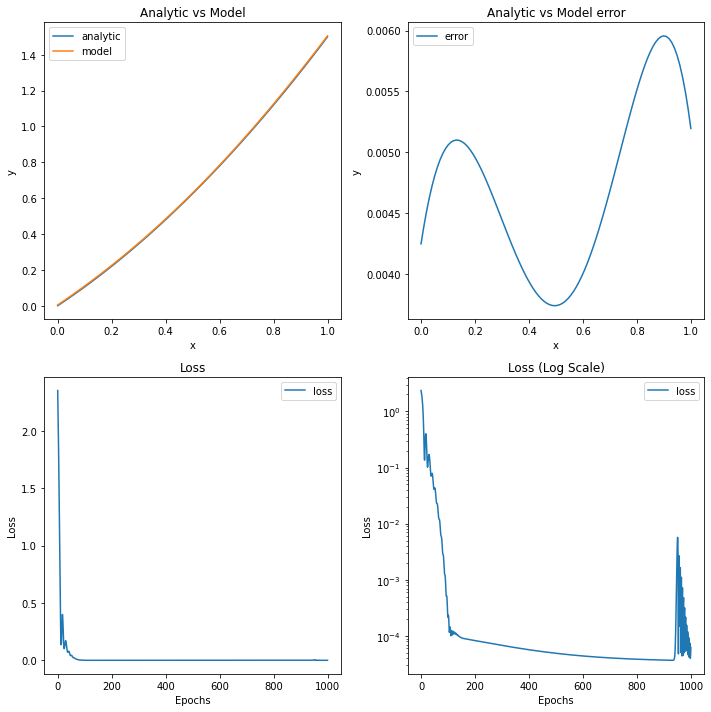

In [10]:
model.eval()

def analytic(x):
    return x**2 * 0.5 + x

x_eval = np.linspace(0,1,100)
y_analytic = analytic(x_eval)
x_eval_tensor = torch.from_numpy(x_eval).float().unsqueeze(-1)
y_model = model(x_eval_tensor).detach().flatten().numpy()

y_error = y_model - y_analytic

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Analytic vs Model
axs[0, 0].plot(x_eval, y_analytic, label="analytic")
axs[0, 0].plot(x_eval, y_model, label="model")
axs[0, 0].legend()
axs[0, 0].set_xlabel("x")
axs[0, 0].set_ylabel("y")
axs[0, 0].set_title("Analytic vs Model")

# Error
axs[0, 1].plot(x_eval, y_error, label="error")
axs[0, 1].legend()
axs[0, 1].set_xlabel("x")
axs[0, 1].set_ylabel("y")
axs[0, 1].set_title("Analytic vs Model error")

# Loss
axs[1, 0].plot(loss_history, label="loss")
axs[1, 0].legend()
axs[1, 0].set_xlabel("Epochs")
axs[1, 0].set_ylabel("Loss")
axs[1, 0].set_title("Loss")

# Loss (Log Scale)
axs[1, 1].plot(loss_history, label="loss")
axs[1, 1].set_yscale("log")
axs[1, 1].legend()
axs[1, 1].set_xlabel("Epochs")
axs[1, 1].set_ylabel("Loss")
axs[1, 1].set_title("Loss (Log Scale)")

plt.tight_layout()
plt.show()